In [110]:
"""
2D Navier-Stokes Equation (vorticity-streamfunction formulation)
    Spatial: CDS and Arakawa scheme
    Temporal: RK3
"""
import sys
import numpy as np
import scipy
from numba import njit,jit,float64,int64

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import scipy.sparse
import numpy.linalg
from tqdm.notebook import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)

%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 1200
matplotlib.rcParams['savefig.dpi'] = 1200
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [111]:
def BoundaryConditionDir(w, s, dX, dY):
    s[0,:] = 0
    s[-1,:] = 0
    s[:,0] = 0
    s[:,-1] = 0

    w[0,:] = (-4*s[1,:] +0.5*s[2,:])/dX**2
    w[-1,:] = (-4*s[-2,:] +0.5*s[-3,:])/dX**2

    w[:,0] = (-4*s[:,1] +0.5*s[:,2])/dY**2
    w[:,-1] = (-4*s[:,-2] +0.5*s[:,-3])/dY**2 + 3/dY # Modified from -3 to +3 to match the verification exercise

In [112]:
def rhs(omega, psi, dX, dY, Re):
    result = psi*0
    viscousContribution = 1/Re*(
        (omega[0:-2,1:-1]+omega[2:,1:-1] - 2*omega[1:-1,1:-1])/dX**2 +
        (omega[1:-1,0:-2]+omega[1:-1,2:] - 2*omega[1:-1,1:-1])/dY**2
    )

    J1 = (
        (omega[2:,1:-1]-omega[0:-2,1:-1])*(psi[1:-1,2:]-psi[1:-1,0:-2]) - 
        (omega[1:-1,2:]-omega[1:-1,0:-2])*(psi[2:,1:-1]-psi[0:-2,1:-1])
    )

    J2 = (
        omega[2:,1:-1]*(psi[2:,2:] - psi[2:,:-2]) -
        omega[:-2,1:-1]*(psi[:-2,2:] - psi[:-2,:-2]) -
        omega[1:-1,2:]*(psi[2:,2:] - psi[:-2,2:]) +
        omega[1:-1,:-2]*(psi[2:,:-2]-psi[:-2,:-2])
    ) 

    J3 = (
        omega[2:,2:]*(psi[1:-1,2:] - psi[2:,1:-1]) -
        omega[:-2,:-2]*(psi[:-2,1:-1] - psi[1:-1,:-2]) -
        omega[:-2,2:]*(psi[1:-1,2:] - psi[:-2,1:-1]) +
        omega[2:,:-2]*(psi[2:,1:-1] - psi[1:-1,:-2])
    )

    result[1:-1,1:-1] = viscousContribution - (J1+J2+J3)/(12*dX*dY)

    return result


In [113]:
def PoissonFSTCentralDiff(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[1:-1,1:-1]
    m = mA[1:-1,1:-1] # important to plus 1
    n = nA[1:-1,1:-1]
    fTilda = scipy.fft.dstn(f)
    u = fA*0
    uTilda = fTilda/(2/dX**2*np.cos(np.pi*m/Nx) + 2/dY**2*np.cos(np.pi*n/Ny)-2/dX**2-2/dY**2+eps)
    u[1:-1,1:-1] = np.real(scipy.fft.idstn(uTilda))
    return u


In [114]:
def RK3NavierStokes(wOrig, sOrig, dX, dY, mA, nA, Nx, Ny, dT, Re, BCFun):
    # First Intermediate
    wOne = wOrig + dT * rhs(wOrig, sOrig, dX, dY, Re)
    sOne = PoissonFSTCentralDiff(-wOne, dX, dY, mA, nA, Nx, Ny)
    BCFun(wOne, sOne, dX, dY)

    # Second Intermediate
    wTwo = 0.75*wOrig + 0.25*wOne + 0.25 * dT * rhs(wOne, sOne, dX, dY, Re)
    sTwo = PoissonFSTCentralDiff(-wTwo, dX, dY, mA, nA, Nx, Ny)
    BCFun(wTwo, sTwo, dX, dY)

    # Second Intermediate
    wNow = 1/3*wOrig + 2/3*wTwo + 2/3 * dT * rhs(wTwo, wTwo, dX, dY, Re)
    sNow = PoissonFSTCentralDiff(-wNow, dX, dY, mA, nA, Nx, Ny)
    BCFun(wNow, sNow, dX, dY)

    return wNow, sNow

In [115]:
xMin, xMax = 0.0, 1.0
yMin, yMax = 0.0, 1.0

tol=1e-9
maxIter=100000

numXCen = 64
numYCen = 64
numXGrid = numXCen+1
numYGrid = numYCen+1

xMat, yMat = np.meshgrid(np.linspace(xMin, xMax, numXGrid), np.linspace(yMin, yMax, numYGrid), indexing="ij")
mMat, nMat = np.meshgrid(np.arange(numXGrid), np.arange(numYGrid), indexing="ij")

xArray = xMat.flatten()
yArray = yMat.flatten()
mArray = mMat.flatten()
nArray = nMat.flatten()

deltaX = xMat[1,0] - xMat[0,0]
deltaY = yMat[0,1] - yMat[0,0]

tStart = 0.0
tEnd = 200.0
deltaT = 1e-3
numStep = np.rint((tEnd-tStart)/deltaT).astype(int)

Re = 1000.0

wInitial = xMat*0
sInitial = xMat*0

wOriginal = wInitial*1
sOriginal = sInitial*1

tNow = tStart

In [116]:
for iStep in tqdm(range(numStep)):
    tNow += deltaT
    wOriginal, sOriginal = RK3NavierStokes(wOriginal, sOriginal, deltaX, deltaY, mMat, nMat, numXCen, numYCen, deltaT, Re, BoundaryConditionDir)

  0%|          | 0/200000 [00:00<?, ?it/s]

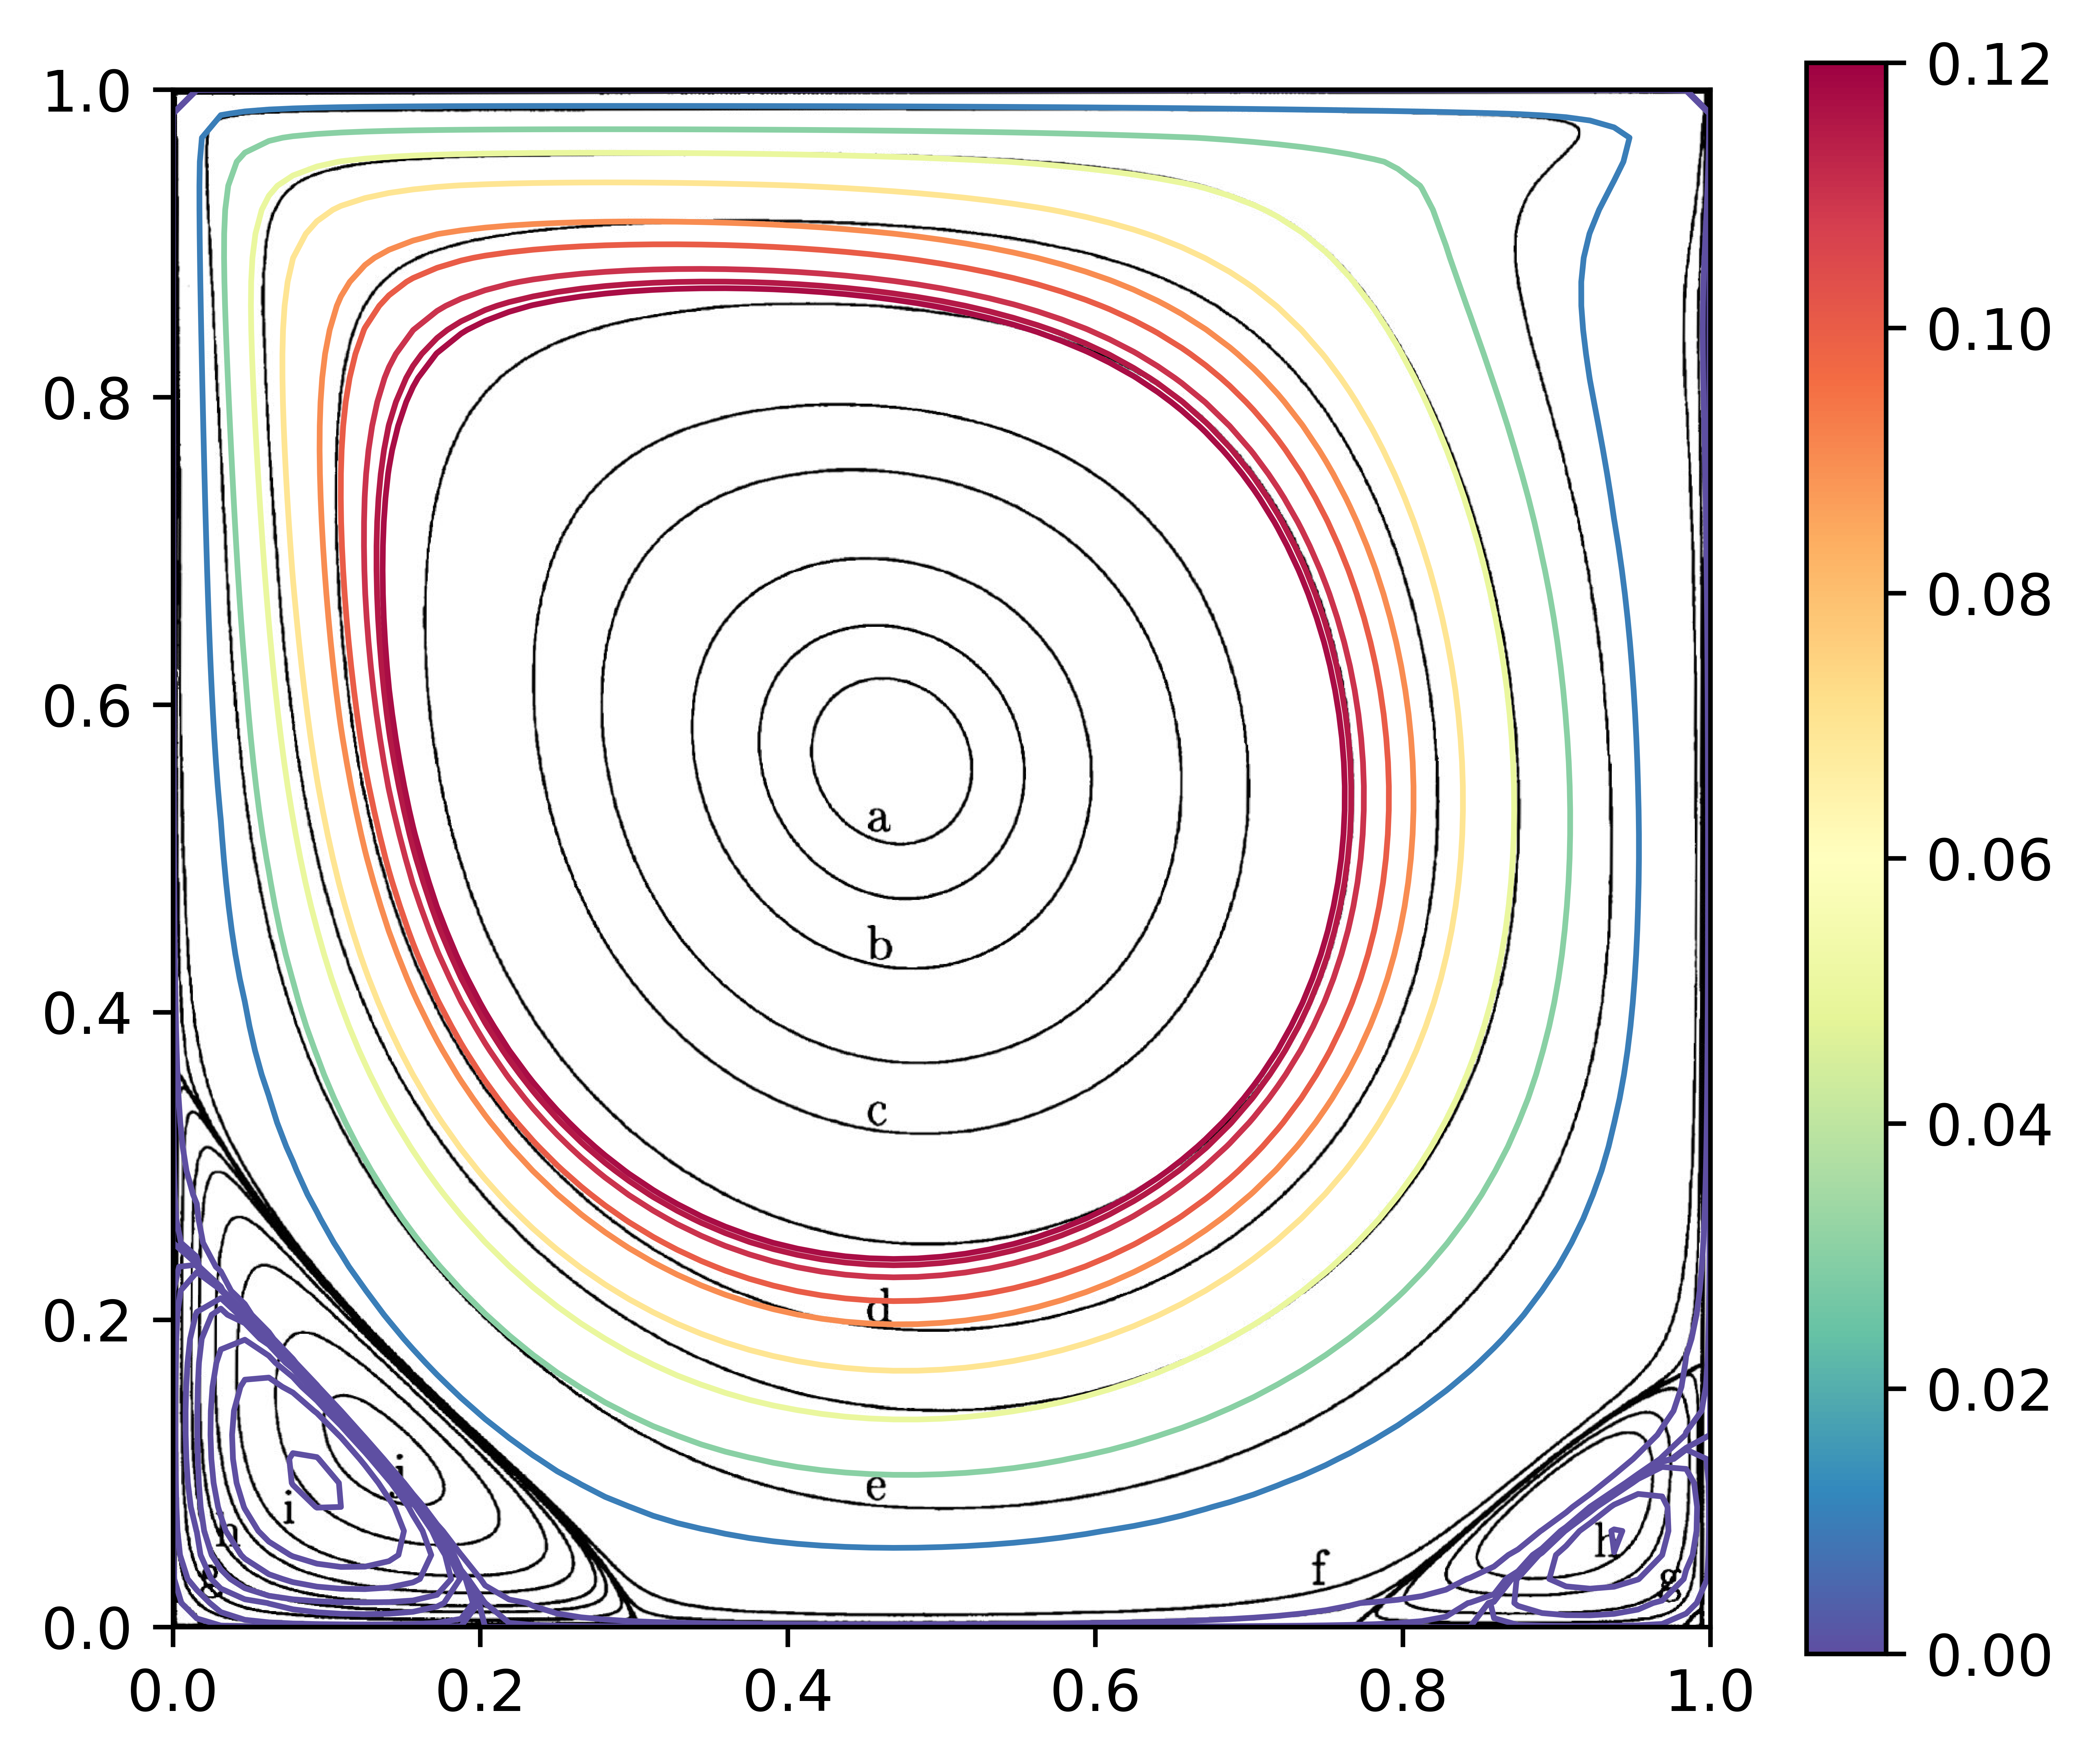

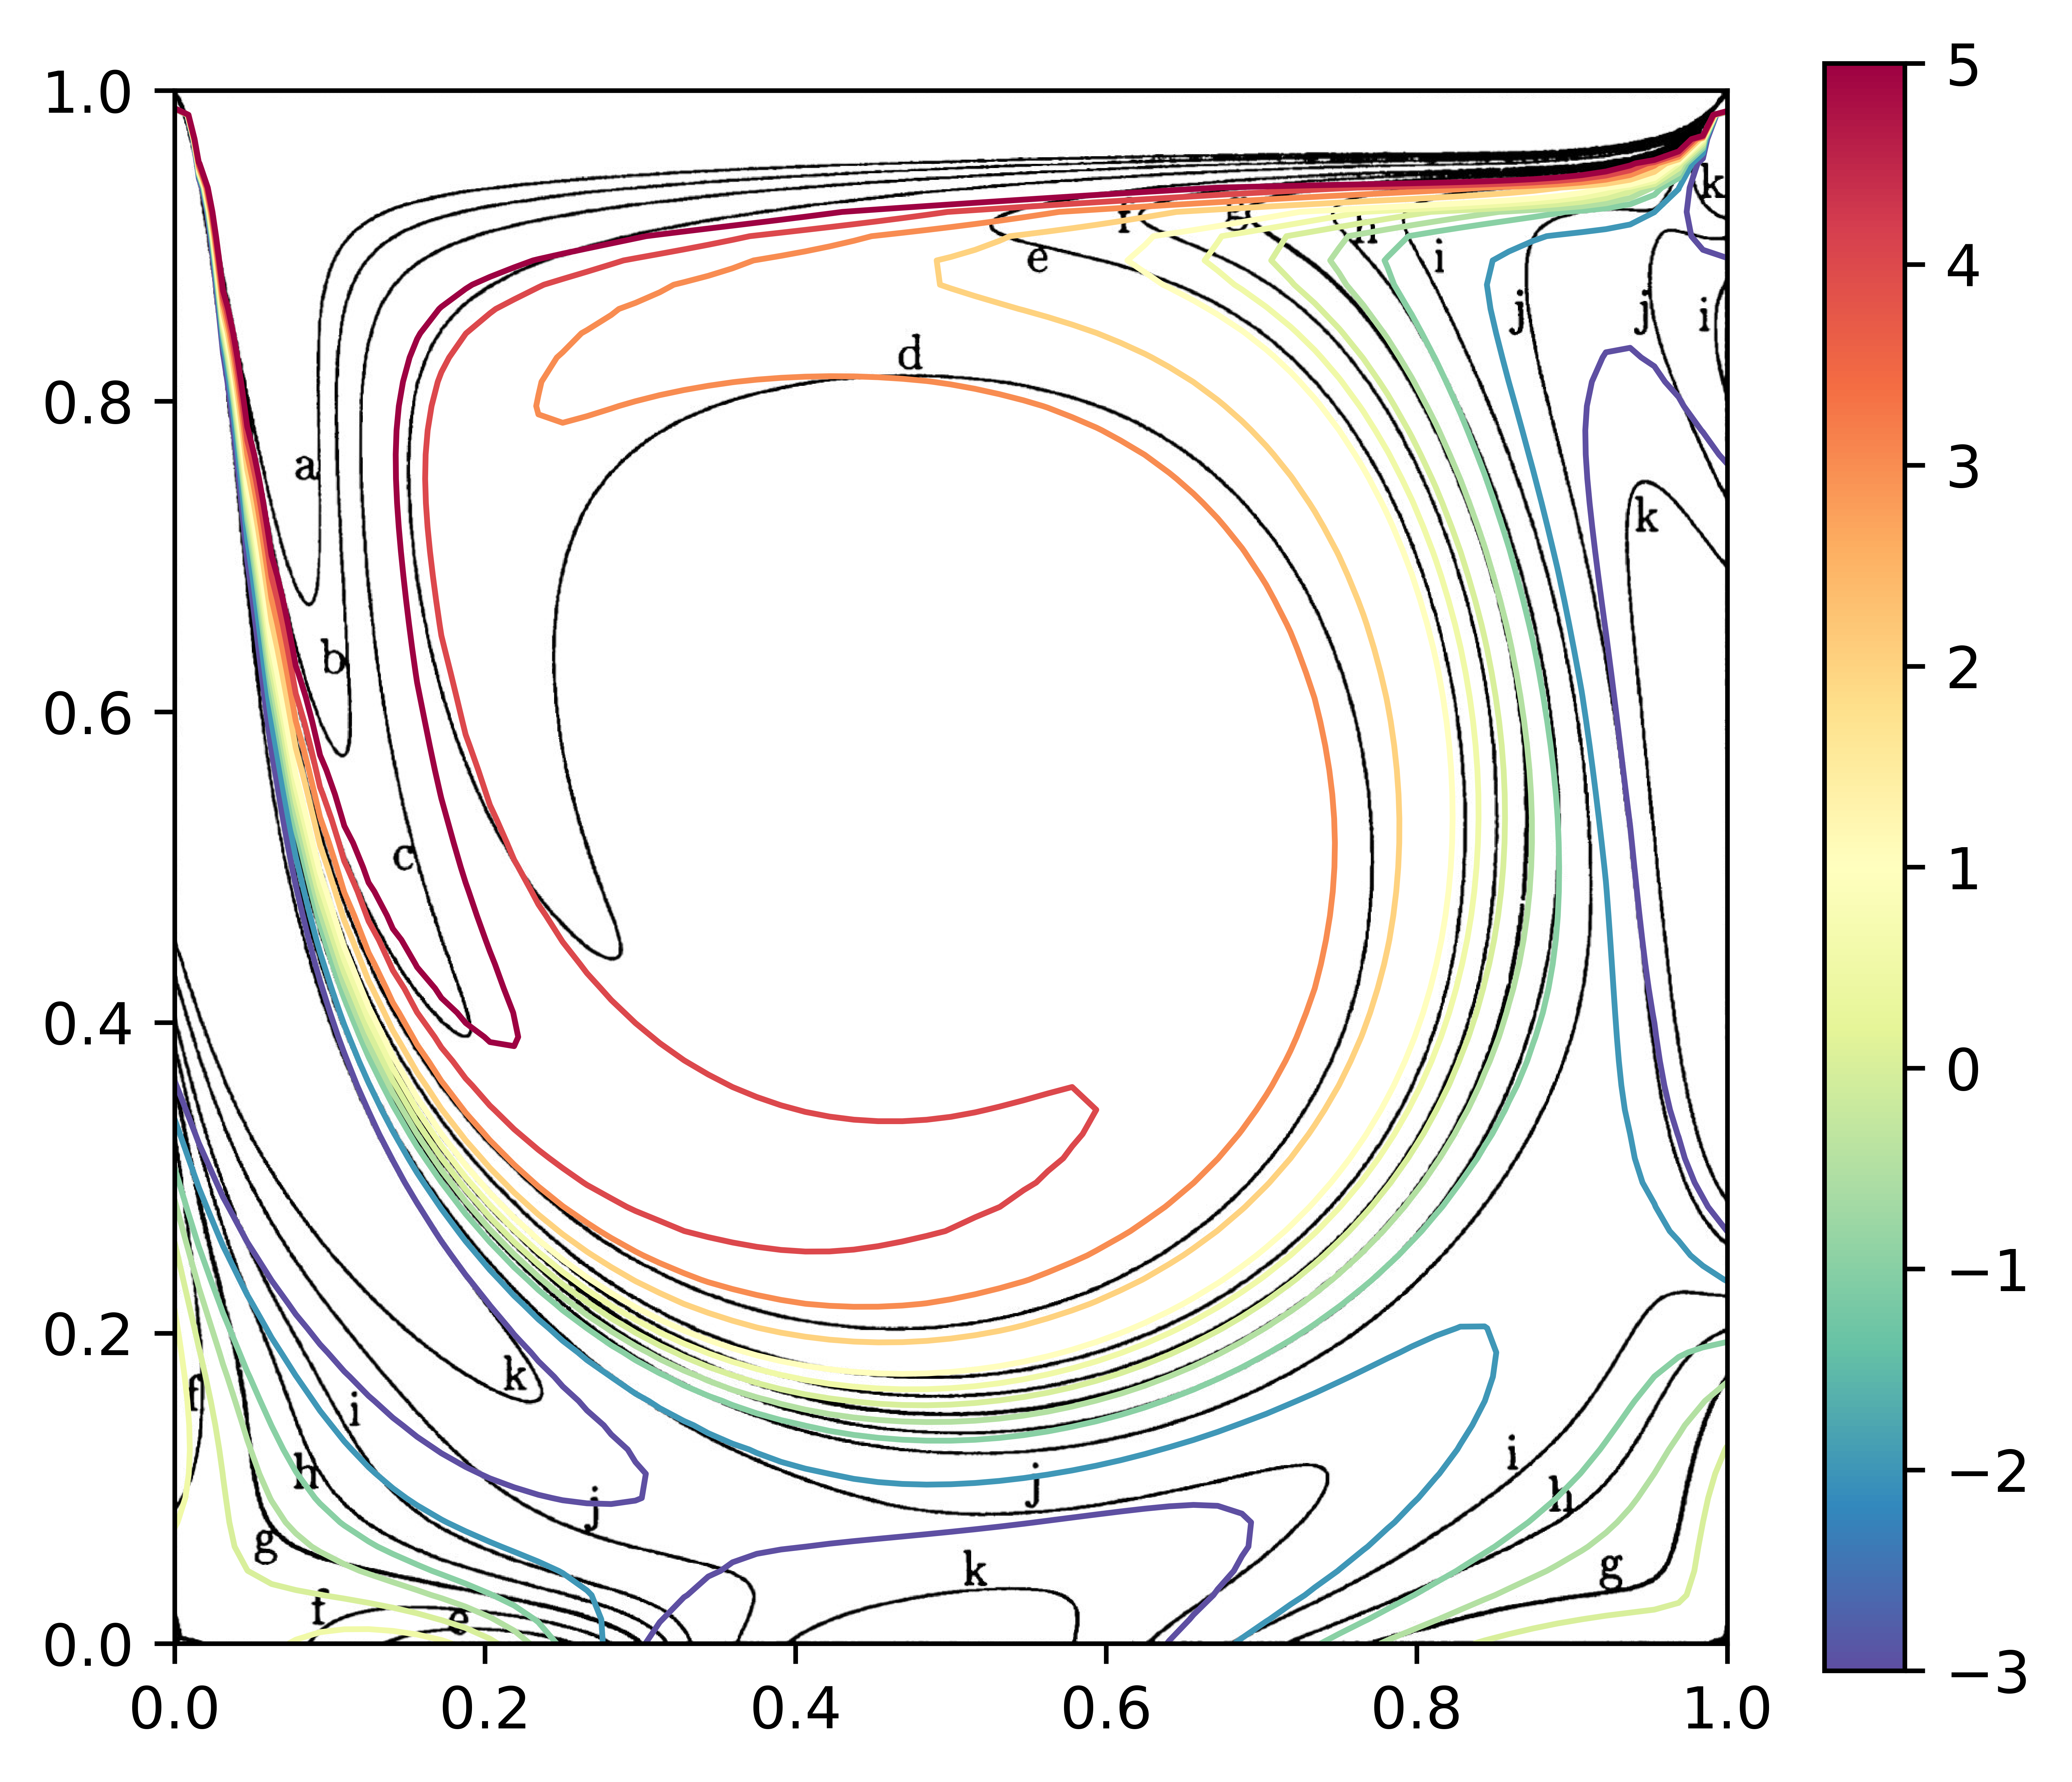

In [117]:
colormap = cm.get_cmap("Spectral_r")

imgS = mpimg.imread("expstream.jpeg")
normalize = mcolors.Normalize(vmin=0, vmax=0.12)
fig, ax = plt.subplots(figsize=(6,5))
level = [-1.5e-3,-1e-3,-5e-4,-2.5e-4,-1e-4,-5e-5,-1e-5,-1e-6,0,1e-10,1e-5,1e-4,1e-2,3e-2,5e-2,7e-2,9e-2,0.1,0.11,0.115,0.1175]
ct = ax.contour(xMat,yMat, sOriginal, levels=level, cmap=colormap, norm=normalize, linewidths=1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
cbar = fig.colorbar(s_map, ax=ax)

imgS = mpimg.imread("expvort.jpeg")
normalize = mcolors.Normalize(vmin=-3, vmax=5)
fig, ax = plt.subplots(figsize=(6,5))
level = [-3,-2,-1,-0.5,0,0.5,1,2,3,4,5]
ct = ax.contour(xMat,yMat, wOriginal, levels=level, cmap=colormap, norm=normalize, linewidths=1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
cbar = fig.colorbar(s_map, ax=ax)